In [130]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle


from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import random
import tensorflow as tf

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [131]:
def get_initial_11(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'][:11].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

## Top 15
Nos sirve para tener mas jugadores para entrenar, no nos interesan todos porque hay algunos que juegan muy poco y pueden cambiar mucho los resultados pero el top 15 suele ser el que mas participa

In [132]:
def get_frequent_players(team, min_minutes=1400):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        
        df_filtered = df[df['MinutesPlayed'] > min_minutes]
        
        df_filtered = df_filtered.sort_values(by='MinutesPlayed', ascending=False)
        
        return df_filtered['PlayerName'].tolist()
    
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [133]:
def get_team_players(team):
    base_path = '//Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [134]:
def load_player_matrix(team_name, player_name, matrix_name):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    if matrix_name != 'pass_transition_matrix':
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.csv')
        matrix = np.loadtxt(matrix_path, delimiter=',')
    else:
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.npy')
        matrix = np.load(matrix_path)
    return matrix

In [135]:
def aggregate_team_matrices(team, players):
    team_matrixes = {
        'pass_matrix':  np.zeros((10, 10)),
        'shot_matrix': np.zeros((10, 10)),
        'defense_matrix': np.zeros((10, 10)),
        'goal_matrix': np.zeros((10, 10)),
        'errors_matrix': np.zeros((10, 10)),
        'out_matrix': np.zeros((10, 10))
    }

    for player in players:
        team_matrixes['pass_matrix'] += load_player_matrix(team, player, 'pass_matrix')
        team_matrixes['shot_matrix'] += load_player_matrix(team, player, 'shot_matrix')
        team_matrixes['defense_matrix'] += load_player_matrix(team, player, 'defense_matrix')
        team_matrixes['goal_matrix'] += load_player_matrix(team, player, 'goal_matrix')
        team_matrixes['errors_matrix'] += load_player_matrix(team, player, 'errors_matrix')
        team_matrixes['out_matrix'] += load_player_matrix(team, player, 'out_matrix') 
    
    return team_matrixes

In [136]:
teams_list = ['Arsenal', 'Everton', 'Fulham', 'Manchester City',
       'Newcastle United', 'Queens Park Rangers', 'Reading',
       'West Bromwich Albion', 'West Ham United', 'Wigan Athletic',
       'Aston Villa', 'Chelsea', 'Liverpool', 'Manchester United',
       'Norwich City', 'Southampton', 'Stoke City', 'Sunderland',
       'Swansea City', 'Tottenham Hotspur', 'Vancouver Whitecaps', 'Philadelphia Union', 'Chivas USA',
       'FC Dallas', 'Seattle Sounders FC', 'Houston Dynamo',
       'Portland Timbers', 'LA Galaxy', 'San Jose Earthquakes',
       'Colorado Rapids', 'Chicago Fire', 'D.C. United', 'Toronto FC',
       'New York Red Bulls', 'Sporting Kansas City', 'Montreal Impact',
       'Real Salt Lake', 'Columbus Crew', 'New England Revolution']

## Construccion del dataframe con informacion de jugadores

In [137]:
base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'

team_matrixes = {}
player_matrixes = {}
all_players = []

for team in teams_list:
    team_csv_path = os.path.join(base_path, f"{team}/{team}_summary.csv")
    team_data = pd.read_csv(team_csv_path)
    
    players = get_frequent_players(team) 
    for player in players:
        if player not in player_matrixes:
            player_matrixes[player] = {}
        
        types = {
           
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'errors_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10))
        }
        
        all_players.append(player)
        
        for type_name in types:
            
            player_matrixes[player][type_name] = load_player_matrix(team, player, type_name)
        
        player_info = team_data[team_data['PlayerName'] == player]
        if not player_info.empty:
            position = player_info['Position'].values[0]
            cards = player_info['Cards'].values[0]
            time_played = player_info['MinutesPlayed'].values[0]
            player_matrixes[player]['team'] = team
            player_matrixes[player]['position'] = position
            player_matrixes[player]['cards'] = cards
            player_matrixes[player]['time'] = time_played

    team_matrixes[team] = aggregate_team_matrices(team, players)

In [138]:
for team in teams_list:
    for matrix in team_matrixes[f'{team}']:
        team_matrixes[f'{team}'][matrix] = np.sum(team_matrixes[f'{team}'][matrix] * 90)

In [139]:
for player in all_players:
    for matrix_name, matrix_value in player_matrixes[f'{player}'].items():
        if matrix_name == 'cards':
            player_matrixes[f'{player}'][matrix_name] = matrix_value * 90
        elif matrix_name == 'time':
            player_matrixes[f'{player}'][matrix_name] = matrix_value / 90
        elif matrix_name == 'position' or matrix_name == 'team':
            pass
        else:
            player_matrixes[f'{player}'][matrix_name] = np.sum(matrix_value * 90)

In [140]:
player_dataframe = pd.DataFrame(player_matrixes).T

In [141]:
player_dataframe['position'] = player_dataframe['position'].replace('Forward', 'Striker')

In [142]:
player_dataframe

,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,time
"Cazorla, Santiago",56.60181,3.02211,10.14408,0.31536,3.75804,2.81196,Arsenal,Midfielder,0.026277,38.055556
"Mertesacker, Per",43.94241,0.47952,10.52028,0.08451,4.31514,1.35297,Arsenal,Defender,0.112817,35.455556
"Arteta, Mikel",73.21698,0.55062,13.47732,0.17388,4.23117,1.5939,Arsenal,Midfielder,0.173913,34.5
"Giroud, Olivier",16.45299,3.92085,7.73109,0.40302,7.73145,3.11355,Arsenal,Striker,0.14658,27.288889
"Walcott, Theo",17.0568,3.28293,4.60359,0.5283,2.30157,2.15019,Arsenal,Striker,0.113208,26.5
...,...,...,...,...,...,...,...,...,...,...
Chris Tierney,27.11772,0.69381,9.49005,0.03654,4.59945,4.08915,New England Revolution,Defender,0.072993,27.4
Scott Caldwell,32.30739,0.26469,11.15973,0.0378,3.9339,1.62603,New England Revolution,Midfielder,0.113493,26.433333
Bobby Shuttleworth,0.0,0.0,0.0,0.0,0.0,0.0,New England Revolution,Goalkeeper,0.0,23.988889
A.J. Soares,22.16727,0.25605,15.3585,0.05121,5.98995,4.04523,New England Revolution,Defender,0.204778,19.533333


## Agregado de metricas de participación

In [143]:
for team in teams_list:
    team_stats = team_matrixes[team]
    for player in get_frequent_players(team):
        if player in player_dataframe.index:
            for stat_name, stat_value in team_stats.items():
                player_dataframe.loc[player, f'{stat_name}_team'] = stat_value

In [144]:
metrics = ['pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 'errors_matrix', 'out_matrix']

for metric in metrics:
    player_dataframe[f'{metric}_contribution'] = player_dataframe[metric] / player_dataframe[f'{metric}_team']

In [145]:
player_dataframe = player_dataframe.round(2)

In [146]:
player_dataframe = player_dataframe.reset_index().rename(columns={'index': 'player'})

## Agregamos la variable a predecir: el ranking

In [147]:
ranking_PL = pd.read_excel('/Users/luisalawson/Desktop/Ranking.xlsx')
ranking_MLS = pd.read_excel('/Users/luisalawson/Desktop/RankingMLS.xlsx')

In [148]:
ranking_PL['League'] = 'PL'
ranking_MLS['League'] = 'MLS'

ranking = pd.concat([ranking_PL, ranking_MLS], ignore_index=True)

In [149]:
ranking 

,Equipo,Posicion,Puntos,League
0,Manchester United,1,89,PL
1,Manchester City,2,78,PL
2,Chelsea,3,75,PL
3,Arsenal,4,73,PL
4,Tottenham Hotspur,5,72,PL
5,Everton,6,63,PL
6,Liverpool,7,61,PL
7,West Bromwich Albion,8,49,PL
8,Swansea City,9,46,PL
9,West Ham United,10,46,PL


In [150]:
ranking.reset_index(drop=True, inplace=True)

In [151]:
player_dataframe = player_dataframe.merge(ranking[['Equipo', 'Posicion', 'League']], left_on='team', right_on='Equipo', how='left')
player_dataframe = player_dataframe.drop(columns=['Equipo'])
player_dataframe = player_dataframe.rename(columns={'Posicion': 'TeamRanking'})

## Modelo clasificador

In [152]:
player_dataframe['TeamRanking'] = player_dataframe['TeamRanking'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else (2 if x <= 12 else (3 if x <= 16 else 4))))

In [153]:
player_dataframe = player_dataframe[player_dataframe['position'] != 'Goalkeeper']

In [154]:
# Si queremos que sean 3 clases (probar mas adelante, ya probe y no dio tanta diferencia, mejor 5)

# player_dataframe['TeamRanking'] = player_dataframe['TeamRanking'].apply(
#     lambda x: 0 if x <= 6 else (1 if x <= 13 else 2)
# )

In [155]:
# eliminamos el nombre (no me aporta en nada), el equipo (porque se correlaciona con el ranking y seria data leak) 
# y el team Ranking porque es lo que queremos predecir
X = player_dataframe.drop(columns=['player', 'team', 'TeamRanking'])
# nos quedamos con la variable a predecir
y = player_dataframe['TeamRanking']

In [156]:
X, y = shuffle(X, y, random_state=42)

In [157]:
# la posicion la pasamos a One Hot encoding porque son categoricas y no nos sirve tenerla asi
X = pd.get_dummies(X, columns=['position'], prefix='position')
X = pd.get_dummies(X, columns=['League'], prefix='League')
# drop de las variables de equipo porque tambien se correlaciona con el ranking (mismos jugadores del mismo equipo tienen esto igual) y 
# estariamos haciendo data leak
X = X.drop(columns = ['pass_matrix_team',
       'shot_matrix_team', 'defense_matrix_team', 'goal_matrix_team',
       'errors_matrix_team', 'out_matrix_team'])

In [158]:
# primero normalizamos los valores (le sirve a los modelos para predecir tener los nros en un rango mas chico creo)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# separamos en los datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# PROBAR MODELOS ACA - Poner los valores de accuracy asi vamos teniendo info 
# (lo puse en la celda que sigue para no tener muy largo aca), si cambiamos uno pegar el viejo en la de abajo, 
# poner los nros y dejar el que probamos aca

# accuracy: 0.9124 - val_accuracy: 0.4792 - test_accuracy: 0.4799
model = models.Sequential([
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    #si cambiamos la agrupacion del ranking cambiar en el out de esta
    layers.Dense(5, activation='softmax')  
])
# model = models.Sequential([
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.2),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.BatchNormalization(),
#     layers.Dense(5, activation='softmax')
# ])
# aca podemos probar con optimizadores pero la loss mantenerla igual x ser categorica (no usar mse)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# probar con patience, esto es si no me mejora la val_loss en 20 iteraciones dejar (xq seguro esta haciendo 
# overfitting o ya no puede levantar mas patrones)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# entrenamos al modelo - probar con epoch y batch size para ver si cambia en algo
history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.1934 - loss: 2.8147 - val_accuracy: 0.2361 - val_loss: 2.7558
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2947 - loss: 2.6658 - val_accuracy: 0.2361 - val_loss: 2.6731
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3411 - loss: 2.5610 - val_accuracy: 0.2500 - val_loss: 2.6120
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3757 - loss: 2.4934 - val_accuracy: 0.2222 - val_loss: 2.5559
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3780 - loss: 2.4317 - val_accuracy: 0.2500 - val_loss: 2.5065
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4360 - loss: 2.3543 - val_accuracy: 0.2500 - val_loss: 2.4630
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4464 - loss: 2.2896 - val_accuracy: 0.2361 - val_loss: 2.4202
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4045 - loss: 2.2424 - val_accuracy: 0.2500 - val_loss: 2.3790
Epoch 9/200

In [ ]:
## MODELOS QUE YA PROBAMOS

# val_acc -> 0.5833 | acc -> 0.9443 | test_acc -> 0.3669
# model = models.Sequential([
#     layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.2),
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.1),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')
# ])

# model = models.Sequential([
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.2),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.BatchNormalization(),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')
# ])


# val_acc -> 0.27 | acc -> 0.6
# model = models.Sequential([
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.02), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.4),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
#     layers.Dropout(0.3),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')  
# ])

# val_acc -> 0.22 | acc -> 0.4

# model = models.Sequential([
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.3),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.2),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')  
# ])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4399 - loss: 1.5148
Test Accuracy: 0.41


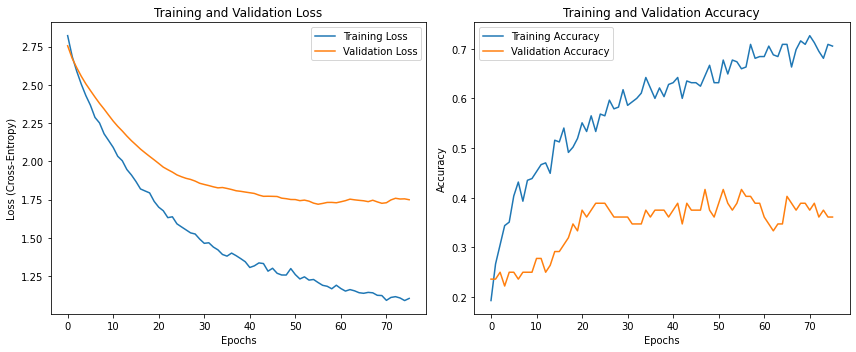

In [159]:
# Vemos como da en test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# graficos de accuracy y de loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [125]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_pred_proba = model.predict(X_test)

roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average="macro")
print(f"Neural Network ROC AUC: {roc_auc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Neural Network ROC AUC: 0.7573


In [126]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_loss}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4694 - loss: 1.9366  
Test MAE: 2.060688018798828


## Random forest & XGBoost

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred_proba = rf_model.predict_proba(X_test)
rf_y_pred = rf_model.predict(X_test)

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
rf_roc_auc = roc_auc_score(y_test_bin, rf_y_pred_proba, average="macro")
print(f"Random Forest ROC AUC: {rf_roc_auc:.4f}")

rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")


Random Forest ROC AUC: 0.6269
Random Forest Accuracy: 0.3222


In [128]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(objective='multi:softmax', num_class=5, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_y_pred_proba = xgb_model.predict_proba(X_test)
xgb_y_pred = xgb_model.predict(X_test)

xgb_roc_auc = roc_auc_score(y_test_bin, xgb_y_pred_proba, average="macro")
print(f"XGBoost ROC AUC: {xgb_roc_auc:.4f}")

xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost ROC AUC: 0.6664
XGBoost Accuracy: 0.3889


## Probando el ranking en base al modelo

In [ ]:
team_rankings_pred = {}

for team in teams_list:
    players = get_initial_11(team)
    player_predictions = []

    for player in players:
        if player in player_matrixes:
            player_row = player_dataframe[player_dataframe['player'] == player].copy()
            
            # Check if player_row is empty
            if player_row.empty:
                print(f"Player {player} not found in player_dataframe.")
                continue  # Skip to the next player

            required_columns = [
                'pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 
                'errors_matrix', 'out_matrix', 'cards', 'time',
                'pass_matrix_contribution', 'shot_matrix_contribution', 
                'defense_matrix_contribution', 'goal_matrix_contribution', 
                'errors_matrix_contribution', 'out_matrix_contribution', 
            ]
            position_columns = [
                'position_Defender', 'position_Midfielder', 
                'position_Striker'
            ]

            player_position = player_row['position'].values[0]
            if player_position == 'Goalkeeper':
                continue  # Skip Goalkeepers

            for pos_col in position_columns:
                player_row.loc[:, pos_col] = 1 if player_position in pos_col else 0

            player_row = player_row[required_columns + position_columns]

            # Ensure the player_row has the necessary columns
            if player_row.empty:
                print(f"No valid data for player {player} after processing.")
                continue

            player_features = pd.DataFrame(player_row[required_columns + position_columns])
            player_features = scaler.transform(player_features)

            player_prediction = model.predict(player_features)
            predicted_class = np.argmax(player_prediction[0])

            player_predictions.append(predicted_class)
        else:
            print(f"Player {player} not found in player_matrixes")

    # Average predictions
    if player_predictions:
        team_rankings_pred[team] = np.mean(player_predictions)
    else:
        print(f"No predictions for team {team}")



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- League_MLS
- League_PL


In [63]:
team_rankings_pred_df = pd.DataFrame(team_rankings_pred.items(), columns=['Team', 'PredictedRanking'])

In [64]:
team_rankings_pred_df.sort_values(by='PredictedRanking', ascending=True)
team_rankings_pred_df = team_rankings_pred_df.merge(ranking[['Equipo', 'Posicion']], left_on='Team', right_on='Equipo', how='left')
team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else (2 if x <= 12 else (3 if x <= 16 else 4))))
# si hacemos con 3 descomentar la de abajo y comentar la de arriba
# team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(
#     lambda x: 0 if x <= 6 else (1 if x <= 13 else 2)
# )

team_rankings_pred_df = team_rankings_pred_df.rename(columns={'PredictedRanking': 'Predicted'})


team_rankings_pred_df['diff'] = team_rankings_pred_df['Real'] - team_rankings_pred_df['Predicted']
team_rankings_pred_df = team_rankings_pred_df[['Team', 'Predicted', 'Real', 'diff']]

In [65]:
teams_PL = ranking_PL['Equipo'].unique()
teams_MLS = ranking_MLS['Equipo'].unique()

In [66]:
team_rankings_pred_df = team_rankings_pred_df.sort_values(by='Predicted', ascending=True)
ranking_PL_pred = team_rankings_pred_df[team_rankings_pred_df['Team'].isin(teams_PL)]
ranking_MLS_pred = team_rankings_pred_df[team_rankings_pred_df['Team'].isin(teams_MLS)]

In [67]:
ranking_PL_pred

,Team,Predicted,Real,diff
11,Chelsea,0.000000,0,0.000000
0,Arsenal,0.100000,0,-0.100000
3,Manchester City,0.100000,0,-0.100000
13,Manchester United,0.200000,0,-0.200000
12,Liverpool,0.600000,1,0.400000
7,West Bromwich Albion,1.000000,1,0.000000
19,Tottenham Hotspur,1.000000,1,0.000000
1,Everton,1.200000,1,-0.200000
2,Fulham,1.900000,2,0.100000
18,Swansea City,2.000000,2,0.000000


In [68]:
ranking_MLS_pred

,Team,Predicted,Real,diff
33,New York Red Bulls,0.300000,0,-0.300000
38,New England Revolution,0.444444,0,-0.444444
36,Real Salt Lake,1.000000,1,0.000000
26,Portland Timbers,1.100000,0,-1.100000
34,Sporting Kansas City,1.200000,0,-1.200000
27,LA Galaxy,1.222222,1,-0.222222
24,Seattle Sounders FC,1.500000,1,-0.500000
29,Colorado Rapids,1.500000,1,-0.500000
35,Montreal Impact,1.800000,2,0.200000
30,Chicago Fire,2.100000,2,-0.100000


## Player swap
#### van Persie, Robin -> Mackie, Jamie

In [32]:
team_rankings_pred = {}

for team in teams_list:
    players = get_initial_11(team)
    if team == 'Manchester United' and 'van Persie, Robin' in players:
        players = [player if player != 'van Persie, Robin' else 'Mackie, Jamie' for player in players]
    
    if team == 'Queens Park Rangers' and 'Mackie, Jamie' in players:
        players = [player if player != 'Mackie, Jamie' else 'van Persie, Robin' for player in players]
        
    player_predictions = []

    for player in players:
        if player in player_matrixes:
            player_row = player_dataframe[player_dataframe['player'] == player].copy()
            required_columns = [
                'pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 
                'errors_matrix', 'out_matrix', 'cards', 'time',
                'pass_matrix_contribution', 'shot_matrix_contribution', 
                'defense_matrix_contribution', 'goal_matrix_contribution', 
                'errors_matrix_contribution', 'out_matrix_contribution'
            ]
            position_columns = [
                'position_Defender', 'position_Goalkeeper', 'position_Midfielder', 
                'position_Striker'
            ]

            player_position = player_row['position'].values[0]
            for pos_col in position_columns:
                player_row.loc[:, pos_col] = 1 if player_position in pos_col else 0

            player_row = player_row[required_columns + position_columns]

            player_features = pd.DataFrame(player_row[required_columns + position_columns])
            player_features = scaler.transform(player_features)

            player_prediction = model.predict(player_features)
            predicted_class = np.argmax(player_prediction[0])

            player_predictions.append(predicted_class)
        else:
            print(f"Player {player} not found in player_matrixes")

    if player_predictions:
        team_rankings_pred[team] = np.mean(player_predictions)
    else:
        print(f"No predictions for team {team}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [33]:
team_rankings_pred_df = pd.DataFrame(team_rankings_pred.items(), columns=['Team', 'PredictedRanking'])

In [34]:
team_rankings_pred_df.sort_values(by='PredictedRanking', ascending=True)
team_rankings_pred_df = team_rankings_pred_df.merge(ranking[['Equipo', 'Posicion']], left_on='Team', right_on='Equipo', how='left')
team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else (2 if x <= 12 else (3 if x <= 16 else 4))))

# si hacemos con 3 descomentar la de abajo y comentar la de arriba
# team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(
#     lambda x: 0 if x <= 6 else (1 if x <= 13 else 2)
# )

team_rankings_pred_df = team_rankings_pred_df.rename(columns={'PredictedRanking': 'Predicted'})

team_rankings_pred_df['diff'] = team_rankings_pred_df['Real'] - team_rankings_pred_df['Predicted']
team_rankings_pred_df = team_rankings_pred_df[['Team', 'Predicted', 'Real', 'diff']]

In [41]:
team_rankings_pred_df.sort_values(by='Predicted', ascending=True)

,Team,Predicted,Real,diff
13,Manchester United,0.000000,0,0.000000
0,Arsenal,0.100000,0,-0.100000
3,Manchester City,0.100000,0,-0.100000
11,Chelsea,0.200000,0,-0.200000
12,Liverpool,0.400000,1,0.600000
19,Tottenham Hotspur,0.900000,1,0.100000
26,Portland Timbers,0.900000,0,-0.900000
1,Everton,1.100000,1,-0.100000
36,Real Salt Lake,1.100000,1,-0.100000
2,Fulham,1.200000,2,0.800000


In [43]:
team_rankings_pred_df = team_rankings_pred_df.sort_values(by='Predicted', ascending=True)

# Create df1 for teams in ranking_PL
df1 = team_rankings_pred_df[team_rankings_pred_df['Team'].isin(teams_PL)]

# Create df2 for teams in ranking_MLS
df2 = team_rankings_pred_df[team_rankings_pred_df['Team'].isin(teams_MLS)]

In [44]:
df1

,Team,Predicted,Real,diff
13,Manchester United,0.0,0,0.0
0,Arsenal,0.1,0,-0.1
3,Manchester City,0.1,0,-0.1
11,Chelsea,0.2,0,-0.2
12,Liverpool,0.4,1,0.6
19,Tottenham Hotspur,0.9,1,0.1
1,Everton,1.1,1,-0.1
2,Fulham,1.2,2,0.8
7,West Bromwich Albion,1.3,1,-0.3
18,Swansea City,1.8,2,0.2


In [48]:
df2['Predicted'] = df2['Predicted'].round(2)
df2['diff'] = df2['diff'].round(2)

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_13184/155843153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Predicted'] = df2['Predicted'].round(2)
/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_13184/155843153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['diff'] = df2['diff'].round(2)


In [49]:
df2

,Team,Predicted,Real,diff
26,Portland Timbers,0.90,0,-0.90
36,Real Salt Lake,1.10,1,-0.10
27,LA Galaxy,1.20,1,-0.20
33,New York Red Bulls,1.30,0,-1.30
25,Houston Dynamo,1.60,2,0.40
30,Chicago Fire,1.70,2,0.30
35,Montreal Impact,1.70,2,0.30
29,Colorado Rapids,2.10,1,-1.10
34,Sporting Kansas City,2.10,0,-2.10
38,New England Revolution,2.11,0,-2.11


## Podemos ver de entrenar modelos por posicion

In [40]:
# hay muy pocos datos x ahora especialmente gk
player_dataframe['position'].value_counts()

position
Midfielder    201
Defender      182
Striker       113
Name: count, dtype: int64

## MLS data interpretation

esto ignorarlo es para preparar datos para tener mas para entrenar

In [37]:
MLS_df = pd.read_excel('/Users/luisalawson/Downloads/MLS-Opta.xlsx')

In [38]:
PL_df = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter = ';')

In [39]:
MLS_df.drop(labels=['competition_name', 'competition_id'], axis=1, inplace=True)

In [40]:
MLS_df.rename(columns={'id': 'match_id', 'id.1': 'id'}, inplace=True)

In [47]:
PL_df

,season_id,match_id,home_team_id,home_team_name,away_team_id,away_team_name,id,event_id,date,time,...,sec,team_id,player_id,playerName,playerPosition,x,y,type,description,outcome
0,2012,441999,3,Arsenal,56,Sunderland,688830980,1,18Aug2012,2:31:54 PM,...,0,3,NaN,NaN,NaN,0,0,34,Team set up,1
1,2012,441999,3,Arsenal,56,Sunderland,1399442519,1,18Aug2012,2:33:35 PM,...,0,56,NaN,NaN,NaN,0,0,34,Team set up,1
2,2012,441999,3,Arsenal,56,Sunderland,1641098842,2,18Aug2012,3:01:59 PM,...,0,3,NaN,NaN,NaN,0,0,32,Start,1
3,2012,441999,3,Arsenal,56,Sunderland,1755825990,2,18Aug2012,3:01:59 PM,...,0,56,NaN,NaN,NaN,0,0,32,Start,1
4,2012,441999,3,Arsenal,56,Sunderland,164697335,3,18Aug2012,3:02:00 PM,...,1,3,17733.0,"Podolski, Lukas",Striker,50,50,1,Pass,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648878,2012,442378,111,Wigan Athletic,7,Aston Villa,428661649,905,19May2013,5:51:58 PM,...,35,111,NaN,NaN,NaN,0,0,30,End,1
648879,2012,442378,111,Wigan Athletic,7,Aston Villa,1411196656,907,19May2013,6:00:29 PM,...,0,111,NaN,NaN,NaN,0,0,30,End,1
648880,2012,442378,111,Wigan Athletic,7,Aston Villa,948803408,908,19May2013,6:00:29 PM,...,0,111,NaN,NaN,NaN,0,0,37,Collection End,1
648881,2012,442378,111,Wigan Athletic,7,Aston Villa,803034702,810,19May2013,6:00:30 PM,...,0,7,NaN,NaN,NaN,0,0,30,End,1


In [42]:
MLS_df.loc[MLS_df['playerName'] == 'NotSpecified', ['playerName', 'playerPosition']] = ''

In [44]:
MLS_df.loc[MLS_df['playerName'].isin(['NotSpecified', 'NotFound']), ['playerName', 'playerPosition']] = ''

In [49]:
MLS_df['time'] = pd.to_datetime(MLS_df['time'], format='%H:%M:%S').dt.strftime('%I:%M:%S %p')
MLS_df['date'] = pd.to_datetime(MLS_df['date'], format='%Y-%m-%d').dt.strftime('%-d%b%Y')

In [51]:
MLS_df.to_csv('/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data/MLS_df.csv', index=False)